In [13]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from nim_env import NimEnv, OptimalPlayer
from helpers import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = NimEnv(seed = 3)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



#-------------------------------- helpers DQN ----------------------------

def to_input(heaps):
    #change the format of the heaps so that it can be used as an input for the neural network. 
    init_state = torch.zeros(9, device = device)
    for i in range(3):
        state = bin(heaps[i])[2:]
        j = 0 
        while j < len(state):
            init_state[i*3 + 2 - j] = np.int16(state[len(state) - 1 - j])
            j += 1
    return init_state.clone().detach()

            
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(9, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 21)

    def forward(self, x):
        x = (x.to(device))
        x = x.view(-1, 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQN_Player(OptimalPlayer):
    def __init__(self, epsilon, player, target_net):
        super(DQN_Player, self).__init__(epsilon = epsilon, player = player)
        self.target_net = target_net
        
    def QL_Move(self, heaps):
        state = to_input(heaps)
        q = self.target_net(state)
        argmax = torch.argmax(q)
        move = torch.tensor([argmax.div(7, rounding_mode="floor")+1, torch.remainder(argmax, 7)+1], device = device)
        action = move
        return move, action
           
    def act(self, heaps, **kwargs):
        return self.QL_Move(heaps)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


#parameters
GAMMA = 0.99
buffer_size = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 500

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
#Epsilon greedy : 
EPS_GREEDY = 0.5 #random.random()
print("epsilon greedy : ", EPS_GREEDY)


policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer =optim.Adam(policy_net.parameters(), lr = 5*1e-4)
criterion = nn.SmoothL1Loss()
memory = ReplayMemory(buffer_size)


steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    #eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > 1-EPS_GREEDY: #eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q = policy_net(state)
            #print("policy predicted : ", q)
            argmax = torch.argmax(q)
            result = torch.tensor([argmax.div(7, rounding_mode="floor")+1, torch.remainder(argmax, 7)+1], device = device)
            #print("select action :", result)
            if  result[0]==0 or result[1] == 0 :
                print("aussercours dans select action avec q = policy_net(state)")
                print(result)
                print("policy predicted : ", q)
            return result
    else:
        result = torch.tensor([random.randrange(1,4), random.randrange(1,8)], device=device, dtype=torch.long)
        #print("if sampel > eps : ", result)
        if  result[0]==0 or result[1] == 0 :
                print("aussercours dans select action avec result = random")
                print(result)
        return result

"""def select_action_target(state):
    q = target_net(state)
    argmax = torch.argmax(q)
    result = torch.tensor([argmax.div(7, rounding_mode="floor")+1, torch.remainder(argmax, 7)+1], device = device)
    return result"""


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    #print("non final mask : ", non_final_mask)
    #print("non final next state : ", [s for s in batch.next_state if s is not None])
    if [s for s in batch.next_state if s is not None] : #is false if the list is empty
        #print("non empty list")
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    else : 
        #print("empty list")
        non_final_next_states = torch.empty(1) 
           
    #print("non final next states after : ", non_final_next_states)                                      
    state_batch = torch.cat(batch.state)
    #print("state batch :", state_batch.shape)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch) #64 x 21
    #print("state action values : ", state_action_values) 
    #print("action ", action_batch)
    #print("action batch : ", (action_batch[::2]-1+(action_batch[1::2]-1)*3))

    state_action_values = state_action_values.gather(1, (action_batch[::2]-1+(action_batch[1::2]-1)*3).view(BATCH_SIZE, 1)) #64 x 1
    #print("state action values after: ", state_action_values.squeeze(1))
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if len(non_final_next_states) > 1:
        #print("target net : ")
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch  #64
    #print("expected state action values : ", expected_state_action_values) #64 x 1

    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss.item()

def DQN_one_game(playerDQN, playerOpt, env):
    heaps, _, _ = env.observe()
    i = 0
    while not env.end:
        if env.current_player == playerOpt.player:
            move = playerOpt.act(heaps)
            heaps, end, winner = env.step(move)
        else: 
            move, action = playerDQN.act(heaps)
            heaps, end, winner = env.step(move)
        
        i += 1
    return env.reward(playerDQN.player)


def Q1_DQN(target_net, nb_games = 20000, eps = 0.2, eps_opt = 0.5, step = 250, seed = None, question = 'q3-1'):
    Rewards = []
    Steps = []
    total_reward = 0.0
    env = NimEnv(seed = seed)
    playerOpt = OptimalPlayer(epsilon = eps_opt, player = 0)
    playerDQN = DQN_Player(epsilon = eps, player = 1, target_net = target_net) 
    for i in range(nb_games):
        #print('New game\n')
        # switch turns at every game
        if i % 2 == 0:
            playerOpt.player = 0
            playerDQN.player = 1
        else:
            playerOpt.player = 1
            playerDQN.player = 0
        
        total_reward += DQN_one_game(playerDQN, playerOpt, env)
        if i % step == step - 1:
            Rewards.append(total_reward / step)
            Steps.append(i)
            total_reward = 0.0
        env.reset()
        #print(playerQL.qvals['746'])
    plt.figure(figsize = (7, 7))
    plt.plot(Steps, Rewards)
    plt.title('Evolution of average reward every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    plt.savefig('./Data/' + question + '.png')


epsilon greedy :  0.5


# TEST

In [14]:
num_episodes = 10001
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    heaps, _, _ = env.observe()
    state = to_input(heaps)
    #print("state : ", state.shape)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        is_available = env.check_valid(action)
        if not is_available: 
            #i.e. if the action is not valid, we give the agent a negative reward
            #print("is not available : ", is_available)
            reward = torch.tensor([-1], device=device)
            next_state = None
            memory.push(state, action, next_state, reward)
            break
            
        else : #if the action is valid, we make a step
            #print("is available : ", is_available)
            heaps, done, reward = env.step(action)
            #env.render()

            if reward == None:
                #the game has not ended, we add a reward of 0.
                reward = torch.tensor([0], device=device)
            else : 
                #the game has ended and we add a reward of 1. 
                reward = torch.tensor([1], device=device)

            if not done:
                next_state = to_input(heaps)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            loss = optimize_model()
            if done:
                #episode_durations.append(t + 1)
                #plot_durations()
                break
    # Update the target network, copying all weights and biases in DQN

    if i_episode % TARGET_UPDATE == 0:
        print(i_episode)
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
plt.ioff()
plt.show()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
Complete
───────────────────────────────────
Heap 1: |||             	 (3)
───────────────────────────────────
Heap 2:                 	 (0)
───────────────────────────────────
Heap 3:                 	 (0)
───────────────────────────────────


Play against one player

In [19]:
Turns = np.array([0,1])
for i in range(5):
    env.reset()
    heaps, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0.5, player=Turns[0]) #not so optimal player (best : epsi = 0)
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1]) #our player
    #env.render()
    while not env.end:
        if env.current_player == player_opt_1.player:
            move = player_opt_1.act(heaps)
        else:
            state = to_input(heaps)
            move = select_action_target(state)
        #print("move : ", move)
        heaps, end, winner = env.step(move)
        #env.render()

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  str(Turns[0]))
            print('DQN player 2 = ' +  str(Turns[1]))
            env.reset()
            break

-------------------------------------------
Game end, winner is player 0
Optimal player 1 = 0
DQN player 2 = 1


AssertionError: You cannot take more objects than there are in the heap

In [16]:
Turns = np.array([0,1])
Player_DQN = DQN_Player(epsilon=0.5, player = Turns[1], target_net = target_net)
Player_opt = OptimalPlayer(epsilon=0.5, player=Turns[0])
reward = QL_one_game(Player_DQN, Player_opt, eps = 0, eps_opt = 0, alpha = 0, gamma = 0, env = env, update = False)

# 3.2

Q.11

In [8]:
num_episodes = 20000
losses = []
print("losses : ", losses)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    heaps, _, _ = env.observe()
    state = to_input(heaps)
    #print("state : ", state.shape)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        is_available = env.check_valid(action)
        if not is_available: 
            #i.e. if the action is not valid, we give the agent a negative reward
            #print("is not available : ")
            reward = torch.tensor([-1], device=device)
            next_state = None
            memory.push(state, action, next_state, reward)
            break
            
        else : #if the action is valid, we make a step
            _, done, reward = env.step(action)
            #env.render()

            if reward == None: 
                reward = torch.tensor([0], device=device)
            else : 
                #print("reward not None : ", reward)
                reward = torch.tensor([reward], device=device)

            # Observe new state
            heaps, _, _ = env.observe()
            if not done:
                next_state = to_input(heaps)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            loss = optimize_model()
            if done:
                #episode_durations.append(t + 1)
                #plot_durations()
                losses.append(loss)
                print("loss : ", loss)
                break
    # Update the target network, copying all weights and biases in DQN

    if i_episode % TARGET_UPDATE == 0:
        print(i_episode)
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
plt.ioff()
plt.show()

losses :  []
0
loss :  0.022673431783914566
500
loss :  0.006362982094287872
1000
1500
2000
loss :  0.004506346769630909
loss :  0.0044937958009541035
2500
loss :  0.004374979995191097
loss :  0.002913573756814003
3000
loss :  0.0028058644384145737
3500
4000
4500
loss :  0.0011636404087767005
5000
5500
loss :  0.0009431239450350404
6000
6500
7000
loss :  0.0008056056103669107
7500
loss :  0.0007395156426355243
8000
8500
loss :  0.000545498332940042
9000
loss :  0.0005287214880809188
9500
loss :  0.0007824922213330865
loss :  0.0005555802490562201
loss :  0.0005575870745815337
loss :  0.00043190139695070684
loss :  0.0008373021264560521
10000
loss :  0.0008611102239228785
10500
loss :  0.0017546917079016566
11000
loss :  0.0005231364048086107
loss :  0.0008728599641472101
11500
loss :  0.0028638294897973537
12000
12500
13000
13500
14000
loss :  0.0008176650735549629
14500
loss :  0.00042911991477012634
15000
15500
loss :  0.0004916220204904675
16000
16500
17000
17500
18000
18500
19000
l

In [12]:
print(losses)
losses = np.array(losses)
aver_losses = (losses.reshape(-1, 250)).mean(axis = 1)
print(aver_losses)


[0.0011116937967017293, 0.0004791765531990677, 0.0014446345157921314, 0.0006353636854328215, 0.0004516641783993691, 0.0005009748274460435, 0.0006440210854634643, 0.0010924437083303928, 0.0003929889062419534, 0.0006850946228951216, 0.0006849135388620198, 0.0003566378145478666, 0.0007577439537271857, 0.0007167788571678102, 0.00022508430993184447, 0.00020175274403300136, 0.000519493711180985, 0.00035526545252650976, 0.00034041202161461115, 0.00026659510331228375, 0.00025759299751371145, 0.000324135588016361, 0.0002875941863749176, 0.00022826428175903857, 0.0002539473935030401, 0.0002804423857014626, 0.00017615678370930254, 0.00019927072571590543, 0.0002800890651997179]


ValueError: cannot reshape array of size 29 into shape (250)

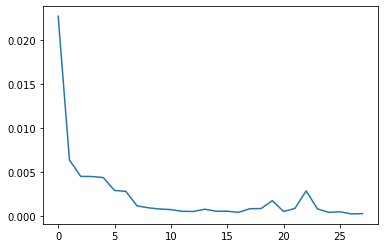

In [9]:
plt.plot(losses)
plt.show()

In [ ]:
Q1_DQN(target_net, nb_games = 20000, eps = 0.2, eps_opt = 0.5, step = 250, seed = None, question = 'q3-1')